#  Facebook Friend recommendation system



<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook 
    
 Challenge</b> </p>

### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from datetime import datetime
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# 1. Reading Data

In [2]:
train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


# 2. Similarity measures

## 2.1 Jaccard Distance:
http://www.statisticshowto.com/jaccard-index/

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [3]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [4]:
#one test case
print(jaccard_for_followees(273084,1505602))

0.0


In [5]:
#node 1635354 not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


In [6]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [7]:
print(jaccard_for_followers(273084,470294))

0


In [8]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0


## 2.2 Cosine distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [9]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [10]:
print(cosine_for_followees(273084,1505602))

0.0


In [11]:
print(cosine_for_followees(273084,1635354))

0


In [12]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [13]:
print(cosine_for_followers(2,470294))

0.02886751345948129


In [14]:
print(cosine_for_followers(669354,1635354))

0


## 3. Ranking Measures

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

<img src='PageRanks-Example.jpg'/>

Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. <b>(The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.</b>

## 3.1 Page Ranking

https://en.wikipedia.org/wiki/PageRank


In [15]:
if not os.path.isfile('page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('page_rank.p','wb'))
else:
    pr = pickle.load(open('page_rank.p','rb'))

In [16]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 1.6556497245737814e-07
max 2.7098251341935827e-05
mean 5.615699699389075e-07


In [17]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.615699699389075e-07


# 4. Other Graph Features

Getting Shortest path between twoo nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path. 

In [18]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [19]:
#testing
compute_shortest_path_length(77697, 826021)

10

In [20]:
#testing
compute_shortest_path_length(669354,1635354)

-1

## 4.2 Checking for same community

In [21]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [22]:
belongs_to_same_wcc(861, 1659750)

0

In [23]:
belongs_to_same_wcc(669354,1635354)

0

## 4.3 Adamic/Adar Index:
Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [24]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [25]:
calc_adar_in(1,189226)

0

In [26]:
calc_adar_in(669354,1635354)

0

## 4.4 Is persion was following back:

In [27]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [28]:
follows_back(1,189226)

1

In [29]:
follows_back(669354,1635354)

0

## 4.5 Katz Centrality:
https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
 Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

In [30]:
if not os.path.isfile('katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('katz.p','wb'))
else:
    katz = pickle.load(open('katz.p','rb'))

In [31]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935562018


In [32]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800935562018


## 4.6 Hits Score
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

https://en.wikipedia.org/wiki/HITS_algorithm

In [33]:
if not os.path.isfile('hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('hits.p','wb'))
else:
    hits = pickle.load(open('hits.p','rb'))

In [34]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.004868653378780953
mean 5.615699699344123e-07


# 5. Featurization

## 5. 1 Reading a sample of Data from both train and test

In [35]:
import random
if os.path.isfile('train_after_eda.csv'):
    filename = "train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

In [36]:
if os.path.isfile('train_after_eda.csv'):
    filename = "test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

In [37]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [38]:
df_final_train = pd.read_csv('train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,205195,79777,1


In [39]:
df_final_test = pd.read_csv('test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,15948,200721,1


## 5.2 Adding a set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [40]:
if not os.path.isfile('storage_sample_stage1.h5'):
    #mapping jaccrd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

        #mapping jaccrd followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [41]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [42]:
from pandas import HDFStore
from pandas import read_hdf
if not os.path.isfile('storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage1.h5', 'test_df',mode='r')

## 5.3 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [43]:
if not os.path.isfile('storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage2.h5', 'test_df',mode='r')

## 5.4 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

it is directed graph so calculated Weighted in and Weighted out differently

In [44]:
#weight for source and destination of each link
from tqdm import tqdm
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1780722/1780722 [00:16<00:00, 105185.82it/s]


In [45]:
if not os.path.isfile('storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [46]:
from pandas import read_hdf
if not os.path.isfile('storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage3.h5', 'test_df',mode='r')

## 5.5 Adding new set of features
we will create these each of these features for both train and test data points

1.SVD features for both source and destination

In [47]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [48]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [49]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [50]:
from scipy.sparse.linalg import svds, eigs
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [51]:
if not os.path.isfile('storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

In [52]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,...,1.983700e-06,1.545078e-13,8.108378e-13,1.719703e-14,-1.355368e-12,4.675311e-13,1.128587e-06,6.616676e-14,9.771076e-13,4.160010e-14
1,205195,79777,1,0,0.083333,0.029074,0.154303,7,13,7,...,1.278566e-11,2.325743e-11,2.849562e-12,7.836231e-14,-2.829424e-12,7.193569e-12,3.266632e-11,2.289061e-11,2.876354e-12,7.521660e-14
2,653352,1273194,1,0,0.000000,0.000000,0.000000,8,13,15,...,3.460525e-10,2.436985e-13,1.788355e-12,1.488904e-15,-1.645881e-12,1.690585e-11,1.947828e-10,7.582006e-12,1.077090e-11,5.139996e-14
3,107099,730283,1,0,0.000000,0.000000,0.000000,10,1,8,...,1.695139e-13,1.956839e-13,2.432803e-11,8.077028e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,375505,465587,1,0,0.000000,0.000000,0.000000,8,33,9,...,1.656584e-11,8.576129e-15,9.882434e-12,3.625550e-17,-5.138761e-12,3.226393e-09,1.177328e-10,1.174281e-12,1.304652e-09,2.281112e-14


In [53]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [54]:
df_final_test.shape

(50002, 55)

### Adding feature svd_dot

svd_dot is Dot product between sourse node svd and destination node svd features

In [55]:
#for train datasets
s1,s2,s3,s4,s5,s6=df_final_train['svd_u_s_1'],df_final_train['svd_u_s_2'],df_final_train['svd_u_s_3'],df_final_train['svd_u_s_4'],df_final_train['svd_u_s_5'],df_final_train['svd_u_s_6']
s7,s8,s9,s10,s11,s12=df_final_train['svd_v_s_1'],df_final_train['svd_v_s_2'],df_final_train['svd_v_s_3'],df_final_train['svd_v_s_4'],df_final_train['svd_v_s_5'],df_final_train['svd_v_s_6']

d1,d2,d3,d4,d5,d6=df_final_train['svd_u_d_1'],df_final_train['svd_u_d_2'],df_final_train['svd_u_d_3'],df_final_train['svd_u_d_4'],df_final_train['svd_u_d_5'],df_final_train['svd_u_d_6']
d7,d8,d9,d10,d11,d12=df_final_train['svd_v_d_1'],df_final_train['svd_v_d_2'],df_final_train['svd_v_d_3'],df_final_train['svd_v_d_4'],df_final_train['svd_v_d_5'],df_final_train['svd_v_d_6']

In [56]:
svd_dot=[]
for i in range(len(np.array(s1))):
    a=[]
    b=[]
    a.append(np.array(s1[i]))
    a.append(np.array(s2[i]))
    a.append(np.array(s3[i]))
    a.append(np.array(s4[i]))
    a.append(np.array(s5[i]))
    a.append(np.array(s6[i]))
    a.append(np.array(s7[i]))
    a.append(np.array(s8[i]))
    a.append(np.array(s9[i]))
    a.append(np.array(s10[i]))
    a.append(np.array(s11[i]))
    a.append(np.array(s12[i]))
    b.append(np.array(d1[i]))
    b.append(np.array(d2[i]))
    b.append(np.array(d3[i]))
    b.append(np.array(d4[i]))
    b.append(np.array(d5[i]))
    b.append(np.array(d6[i]))
    b.append(np.array(d7[i]))
    b.append(np.array(d8[i]))
    b.append(np.array(d9[i]))
    b.append(np.array(d10[i]))
    b.append(np.array(d11[i]))
    b.append(np.array(d12[i]))
    svd_dot.append(np.dot(a,b))
df_final_train['svd_dot']=svd_dot

In [57]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,...,1.545078e-13,8.108378e-13,1.719703e-14,-1.355368e-12,4.675311e-13,1.128587e-06,6.616676e-14,9.771076e-13,4.160010e-14,1.338832e-11
1,205195,79777,1,0,0.083333,0.029074,0.154303,7,13,7,...,2.325743e-11,2.849562e-12,7.836231e-14,-2.829424e-12,7.193569e-12,3.266632e-11,2.289061e-11,2.876354e-12,7.521660e-14,1.430356e-21
2,653352,1273194,1,0,0.000000,0.000000,0.000000,8,13,15,...,2.436985e-13,1.788355e-12,1.488904e-15,-1.645881e-12,1.690585e-11,1.947828e-10,7.582006e-12,1.077090e-11,5.139996e-14,1.033440e-18
3,107099,730283,1,0,0.000000,0.000000,0.000000,10,1,8,...,1.956839e-13,2.432803e-11,8.077028e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.377123e-25
4,375505,465587,1,0,0.000000,0.000000,0.000000,8,33,9,...,8.576129e-15,9.882434e-12,3.625550e-17,-5.138761e-12,3.226393e-09,1.177328e-10,1.174281e-12,1.304652e-09,2.281112e-14,1.719638e-20


In [58]:
#for test dataset
s1,s2,s3,s4,s5,s6=df_final_test['svd_u_s_1'],df_final_test['svd_u_s_2'],df_final_test['svd_u_s_3'],df_final_test['svd_u_s_4'],df_final_test['svd_u_s_5'],df_final_test['svd_u_s_6']
s7,s8,s9,s10,s11,s12=df_final_test['svd_v_s_1'],df_final_test['svd_v_s_2'],df_final_test['svd_v_s_3'],df_final_test['svd_v_s_4'],df_final_test['svd_v_s_5'],df_final_test['svd_v_s_6']

d1,d2,d3,d4,d5,d6=df_final_test['svd_u_d_1'],df_final_test['svd_u_d_2'],df_final_test['svd_u_d_3'],df_final_test['svd_u_d_4'],df_final_test['svd_u_d_5'],df_final_test['svd_u_d_6']
d7,d8,d9,d10,d11,d12=df_final_test['svd_v_d_1'],df_final_test['svd_v_d_2'],df_final_test['svd_v_d_3'],df_final_test['svd_v_d_4'],df_final_test['svd_v_d_5'],df_final_test['svd_v_d_6']

In [59]:
svd_dot=[]
for i in range(len(np.array(s1))):
    a=[]
    b=[]
    a.append(np.array(s1[i]))
    a.append(np.array(s2[i]))
    a.append(np.array(s3[i]))
    a.append(np.array(s4[i]))
    a.append(np.array(s5[i]))
    a.append(np.array(s6[i]))
    a.append(np.array(s7[i]))
    a.append(np.array(s8[i]))
    a.append(np.array(s9[i]))
    a.append(np.array(s10[i]))
    a.append(np.array(s11[i]))
    a.append(np.array(s12[i]))
    b.append(np.array(d1[i]))
    b.append(np.array(d2[i]))
    b.append(np.array(d3[i]))
    b.append(np.array(d4[i]))
    b.append(np.array(d5[i]))
    b.append(np.array(d6[i]))
    b.append(np.array(d7[i]))
    b.append(np.array(d8[i]))
    b.append(np.array(d9[i]))
    b.append(np.array(d10[i]))
    b.append(np.array(d11[i]))
    b.append(np.array(d12[i]))
    svd_dot.append(np.dot(a,b))
df_final_test['svd_dot']=svd_dot

In [60]:
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot
0,848424,784690,1,0,0.000000,0.029161,0.000000,6,14,6,...,2.701539e-12,4.341606e-13,5.535504e-14,-9.994077e-10,5.791914e-10,3.512339e-07,2.486665e-09,2.771146e-09,1.727695e-12,2.083218e-17
1,15948,200721,1,0,0.000000,0.100000,0.000000,4,10,0,...,2.520944e-16,3.778440e-16,8.958459e-19,-2.187868e-15,1.005728e-12,3.154582e-13,5.307108e-15,7.120914e-15,1.976642e-17,2.500147e-26
2,1747456,75621,1,0,0.000000,0.000000,0.000000,11,15,12,...,5.259882e-11,1.216414e-12,1.273184e-13,-1.876396e-09,1.128546e-10,2.659748e-10,1.333588e-10,3.909759e-10,2.235240e-11,1.015990e-20
3,1451525,350908,1,0,0.008475,0.000000,0.053606,110,1,116,...,4.608582e-11,3.285260e-10,5.225511e-12,-1.503369e-12,2.155005e-13,1.375825e-06,2.544765e-13,9.177587e-13,1.507649e-13,1.288688e-09
4,1247061,1676547,1,0,0.000000,0.000000,0.000000,1,2,0,...,2.958934e-16,2.248526e-15,7.051619e-18,-2.140814e-15,2.282094e-13,4.679977e-13,4.280807e-14,1.688489e-13,1.178052e-16,3.934598e-26


### Adding new feature Preferential Attachement

One well-known concept in social networks is that users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has.

#### Preferential Attachement for followers

In [61]:
#for train dataset
nfs=np.array(df_final_train['num_followers_s'])
nfd=np.array(df_final_train['num_followers_d'])
preferential_followers=[]
for i in range(len(nfs)):
    preferential_followers.append(nfd[i]*nfs[i])
df_final_train['prefer_Attach_followers']= preferential_followers
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot,prefer_Attach_followers
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,...,8.108378e-13,1.719703e-14,-1.355368e-12,4.675311e-13,1.128587e-06,6.616676e-14,9.771076e-13,4.160010e-14,1.338832e-11,66
1,205195,79777,1,0,0.083333,0.029074,0.154303,7,13,7,...,2.849562e-12,7.836231e-14,-2.829424e-12,7.193569e-12,3.266632e-11,2.289061e-11,2.876354e-12,7.521660e-14,1.430356e-21,91
2,653352,1273194,1,0,0.000000,0.000000,0.000000,8,13,15,...,1.788355e-12,1.488904e-15,-1.645881e-12,1.690585e-11,1.947828e-10,7.582006e-12,1.077090e-11,5.139996e-14,1.033440e-18,104
3,107099,730283,1,0,0.000000,0.000000,0.000000,10,1,8,...,2.432803e-11,8.077028e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.377123e-25,10
4,375505,465587,1,0,0.000000,0.000000,0.000000,8,33,9,...,9.882434e-12,3.625550e-17,-5.138761e-12,3.226393e-09,1.177328e-10,1.174281e-12,1.304652e-09,2.281112e-14,1.719638e-20,264


In [62]:
#for test dataset
nfs=np.array(df_final_test['num_followers_s'])
nfd=np.array(df_final_test['num_followers_d'])
preferential_followers=[]
for i in range(len(nfs)):
    preferential_followers.append(nfd[i]*nfs[i])
df_final_test['prefer_Attach_followers']= preferential_followers
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot,prefer_Attach_followers
0,848424,784690,1,0,0.000000,0.029161,0.000000,6,14,6,...,4.341606e-13,5.535504e-14,-9.994077e-10,5.791914e-10,3.512339e-07,2.486665e-09,2.771146e-09,1.727695e-12,2.083218e-17,84
1,15948,200721,1,0,0.000000,0.100000,0.000000,4,10,0,...,3.778440e-16,8.958459e-19,-2.187868e-15,1.005728e-12,3.154582e-13,5.307108e-15,7.120914e-15,1.976642e-17,2.500147e-26,40
2,1747456,75621,1,0,0.000000,0.000000,0.000000,11,15,12,...,1.216414e-12,1.273184e-13,-1.876396e-09,1.128546e-10,2.659748e-10,1.333588e-10,3.909759e-10,2.235240e-11,1.015990e-20,165
3,1451525,350908,1,0,0.008475,0.000000,0.053606,110,1,116,...,3.285260e-10,5.225511e-12,-1.503369e-12,2.155005e-13,1.375825e-06,2.544765e-13,9.177587e-13,1.507649e-13,1.288688e-09,110
4,1247061,1676547,1,0,0.000000,0.000000,0.000000,1,2,0,...,2.248526e-15,7.051619e-18,-2.140814e-15,2.282094e-13,4.679977e-13,4.280807e-14,1.688489e-13,1.178052e-16,3.934598e-26,2


### Preferential Attachement for followees

In [63]:
#for train dataset
nfs=np.array(df_final_train['num_followees_s'])
nfd=np.array(df_final_train['num_followees_d'])
preferential_followees=[]
for i in range(len(nfs)):
    preferential_followees.append(nfd[i]*nfs[i])
df_final_train['prefer_Attach_followees']= preferential_followees
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot,prefer_Attach_followers,prefer_Attach_followees
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,...,1.719703e-14,-1.355368e-12,4.675311e-13,1.128587e-06,6.616676e-14,9.771076e-13,4.160010e-14,1.338832e-11,66,120
1,205195,79777,1,0,0.083333,0.029074,0.154303,7,13,7,...,7.836231e-14,-2.829424e-12,7.193569e-12,3.266632e-11,2.289061e-11,2.876354e-12,7.521660e-14,1.430356e-21,91,42
2,653352,1273194,1,0,0.000000,0.000000,0.000000,8,13,15,...,1.488904e-15,-1.645881e-12,1.690585e-11,1.947828e-10,7.582006e-12,1.077090e-11,5.139996e-14,1.033440e-18,104,360
3,107099,730283,1,0,0.000000,0.000000,0.000000,10,1,8,...,8.077028e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.377123e-25,10,24
4,375505,465587,1,0,0.000000,0.000000,0.000000,8,33,9,...,3.625550e-17,-5.138761e-12,3.226393e-09,1.177328e-10,1.174281e-12,1.304652e-09,2.281112e-14,1.719638e-20,264,0


In [64]:
#for test dataset
nfs=np.array(df_final_test['num_followees_s'])
nfd=np.array(df_final_test['num_followees_d'])
preferential_followees=[]
for i in range(len(nfs)):
    preferential_followees.append(nfd[i]*nfs[i])
df_final_test['prefer_Attach_followees']= preferential_followees
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot,prefer_Attach_followers,prefer_Attach_followees
0,848424,784690,1,0,0.000000,0.029161,0.000000,6,14,6,...,5.535504e-14,-9.994077e-10,5.791914e-10,3.512339e-07,2.486665e-09,2.771146e-09,1.727695e-12,2.083218e-17,84,54
1,15948,200721,1,0,0.000000,0.100000,0.000000,4,10,0,...,8.958459e-19,-2.187868e-15,1.005728e-12,3.154582e-13,5.307108e-15,7.120914e-15,1.976642e-17,2.500147e-26,40,0
2,1747456,75621,1,0,0.000000,0.000000,0.000000,11,15,12,...,1.273184e-13,-1.876396e-09,1.128546e-10,2.659748e-10,1.333588e-10,3.909759e-10,2.235240e-11,1.015990e-20,165,0
3,1451525,350908,1,0,0.008475,0.000000,0.053606,110,1,116,...,5.225511e-12,-1.503369e-12,2.155005e-13,1.375825e-06,2.544765e-13,9.177587e-13,1.507649e-13,1.288688e-09,110,348
4,1247061,1676547,1,0,0.000000,0.000000,0.000000,1,2,0,...,7.051619e-18,-2.140814e-15,2.282094e-13,4.679977e-13,4.280807e-14,1.688489e-13,1.178052e-16,3.934598e-26,2,0


In [65]:
hdf = HDFStore('storage_sample_stage5.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

In [66]:
print(df_final_train.shape)
df_final_train.columns

(100002, 58)


Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6', 'svd_dot',
       'prefer_Attach_followers', 'prefer_Attach_followees'],
      dtype='object')

### Modelling

In [3]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

In [4]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [5]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [6]:
df_final_train.shape

(100002, 52)

In [7]:
df_final_test.shape

(50002, 52)

### Random Forset

Estimators =  10 Train Score 0.9162379522499632 test Score 0.8837360353338529
Estimators =  50 Train Score 0.9222813115028684 test Score 0.9102172437202987
Estimators =  100 Train Score 0.9220277383240038 test Score 0.9100021146119688
Estimators =  250 Train Score 0.9207126855515776 test Score 0.9095260282095811
Estimators =  450 Train Score 0.9216508866453941 test Score 0.9125208610600587


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

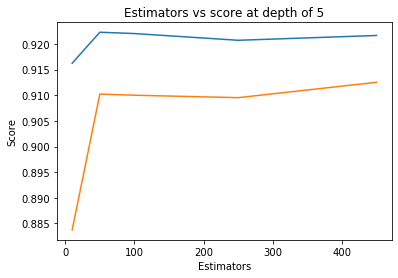

In [71]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8783153630282953 test Score 0.8521472260044523
depth =  9 Train Score 0.9590475024485798 test Score 0.9209783830798277
depth =  11 Train Score 0.963231845341273 test Score 0.9204218600191755
depth =  15 Train Score 0.9640261331155573 test Score 0.9195701864946274
depth =  20 Train Score 0.9646156669997757 test Score 0.9211979111158478
depth =  35 Train Score 0.9647807594626847 test Score 0.921230467500906
depth =  50 Train Score 0.9647807594626847 test Score 0.921230467500906
depth =  70 Train Score 0.9647807594626847 test Score 0.921230467500906
depth =  130 Train Score 0.9647807594626847 test Score 0.921230467500906


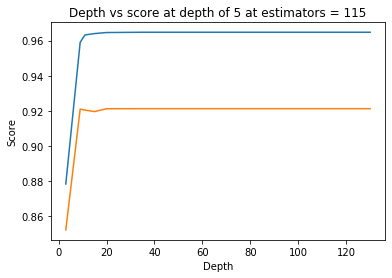

In [72]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [91]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])


mean test scores [0.96239751 0.9620468  0.96054686 0.96164478 0.96322725]


In [92]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=121,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


In [93]:
clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [94]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [95]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9650568094815177
Test f1 score 0.9216971664068673


In [15]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


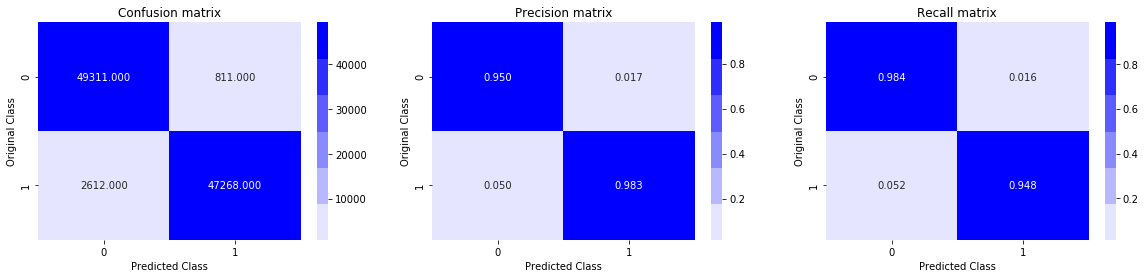

Test confusion_matrix


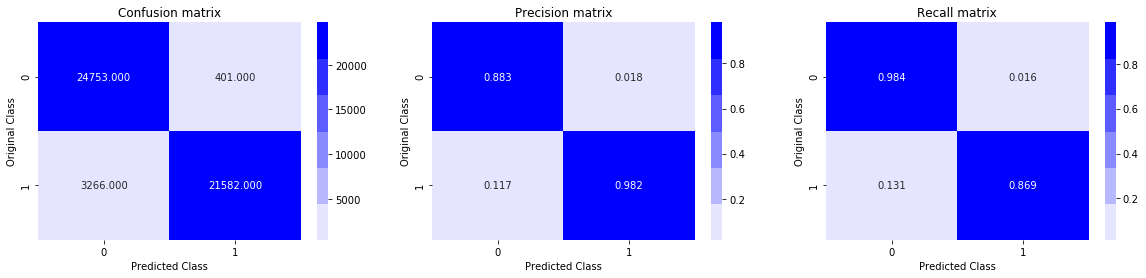

In [97]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

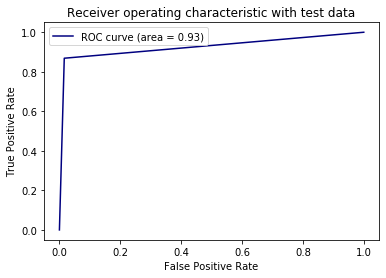

In [98]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

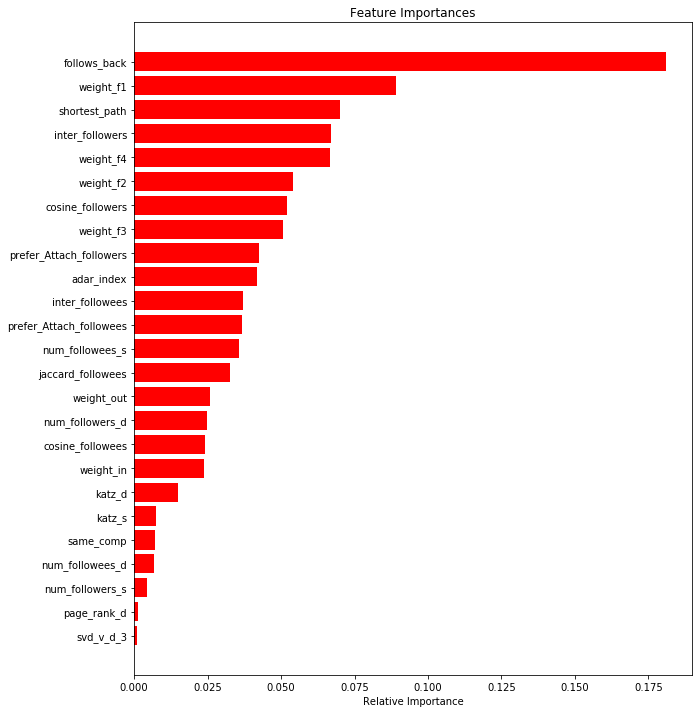

In [99]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### XGBOOST model

In [9]:
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
clf = xgb.XGBClassifier()
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15)
              }
model = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='f1',random_state=25)


model.fit(df_final_train,y_train)
print('mean test scores',model.cv_results_['mean_test_score'])

mean test scores [0.98058819 0.98060944 0.98164322 0.98104455 0.98110244]


In [10]:
print(model.best_estimator_)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=109, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)


In [11]:
clf=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
       n_estimators=112, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [12]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [13]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9953845689750526
Test f1 score 0.9186676994577846


Train confusion_matrix


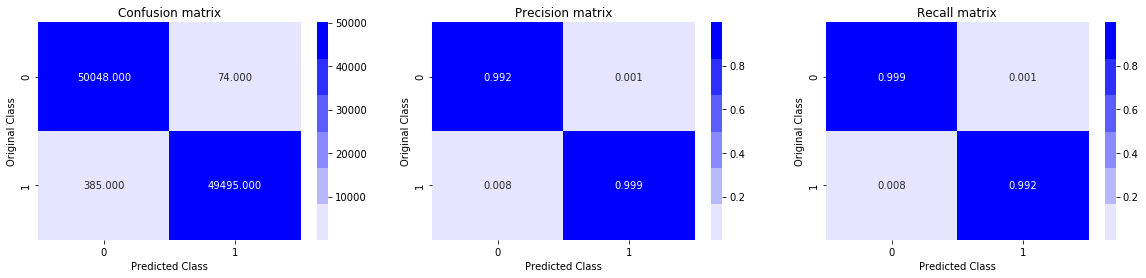

Test confusion_matrix


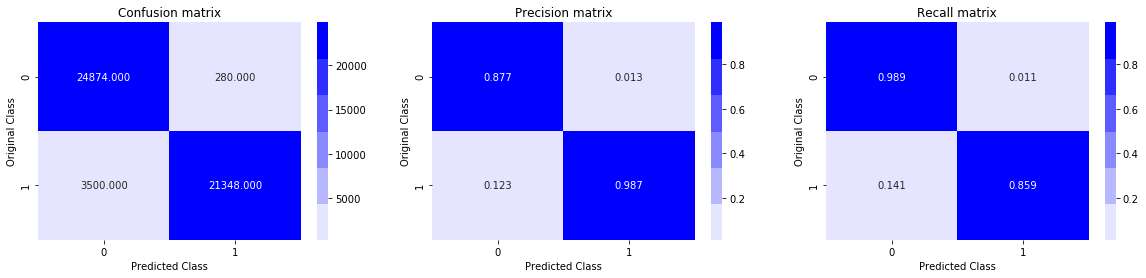

In [16]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

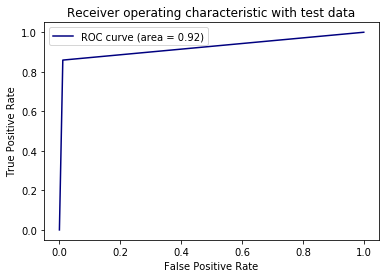

In [17]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

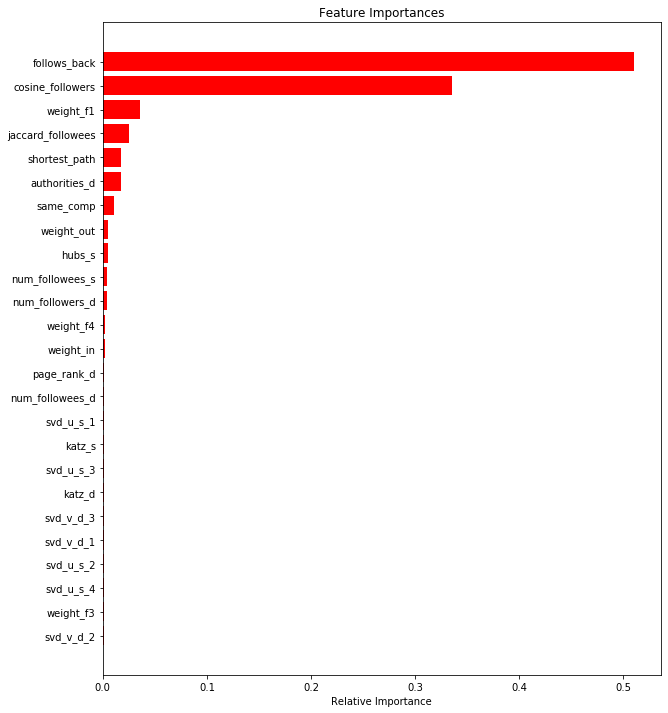

In [20]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [22]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Model", "Train f1-Score","Test f1-Score"]
x.add_row(['Random Forest',0.9650, 0.9216])
x.add_row(['XGBOOST',0.9953,0.9186])
print(x)

+---------------+----------------+---------------+
|     Model     | Train f1-Score | Test f1-Score |
+---------------+----------------+---------------+
| Random Forest |     0.965      |     0.9216    |
|    XGBOOST    |     0.9953     |     0.9186    |
+---------------+----------------+---------------+
